# Compare datasets

In [1]:
import os
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd

import app.tokenizer as atk
import app.datasets as ads

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

from sklearn.feature_extraction.text import TfidfVectorizer

# initialize path to datasets
data_folder = os.path.join("c:/", "datasets")

training_data = [
#     {
#         'label' : '300bad300good',
#         'data': Path(join(data_folder, '300-300.csv'))
#     },
#     {
#         'label' : '300bad3000good',
#         'data': Path(join(data_folder, '300-3000.csv'))
#     },
    {
        'label' : '300bad30000good',
        'data': Path(join(data_folder, '300-30000.csv'))
    },
#     {
#         'label' : '300bad300000good',
#         'data': Path(join(data_folder, '300-300000.csv'))
#     }
]

test_data = Path(join(data_folder, 'bg-test.csv'))

def to_binary(ls):
    fin = list()
    for y in ls:
        if isinstance(y, str) and y == 'bad':
            fin.append(0)
        elif isinstance(y, float) and y < 0.5:
            fin.append(0)
        else:
            fin.append(1)
    return fin

In [4]:
# create dataframe (Pandas)
df_test = pd.read_csv(test_data, ',', error_bad_lines=False)

# converting dataframe into an array
dfa_test = np.array(df_test)

# shuffle data
np.random.shuffle(dfa_test)

# all labels
y_test = [d[1] for d in dfa_test]

# all urls corresponding to a label (either good or bad)
corpus_test = [d[0] for d in dfa_test]

# get a vector for each url but use our customized tokenizer
vectorizer = TfidfVectorizer(tokenizer=atk.get_tokens, stop_words=atk.unwanted_words)

# get the X vector
x_test = vectorizer.fit_transform(corpus_test)

In [28]:
import sklearn.metrics as metrics

def pr_threshold(clf, threshold=0.5): 
    probs_y = clf.predict_proba(x_test)
    
    bool_prediction = probs_y[:, 1] #> threshold
    print(bool_prediction)
    
    precision, recall, thresholds = precision_recall_curve(to_binary(y_test), bool_prediction) 

    #retrieve probability of being 1(in second column of probs_y)
    pr_auc = metrics.auc(recall, precision)

    %matplotlib inline
    
    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])

In [29]:
from inspect import signature
from sklearn.metrics import average_precision_score

def pr_curve(clf, threshold=0.5):
    probs_y = clf.predict_proba(x_test)
    yt = to_binary(y_test)
    
    bool_prediction = probs_y[:, 1] #> threshold
    
    print(bool_prediction)
    
    average_precision = average_precision_score(yt, bool_prediction)
    precision, recall, _ = precision_recall_curve(yt, bool_prediction)

    %matplotlib inline
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

300bad30000good
             precision    recall  f1-score   support

        bad       0.99      0.50      0.66      5000
       good       0.66      0.99      0.80      5000

avg / total       0.82      0.74      0.73     10000

[0.66161458 0.24488018 0.98628843 ... 0.97632427 0.98638388 0.88589044]


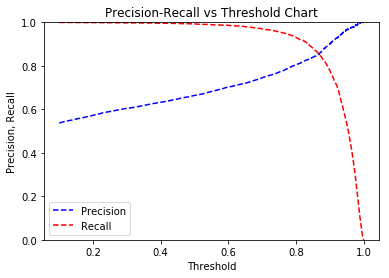

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

for data in training_data:
    # create dataframe (Pandas)
    df = pd.read_csv(data['data'], ',', error_bad_lines=False)

    # converting dataframe into an array
    dfa = np.array(df)

    # shuffle data
    np.random.shuffle(dfa)
    
    # all labels
    y = [d[1] for d in dfa]
    
    # all urls corresponding to a label (either good or bad)
    corpus = [d[0] for d in dfa]

    # get the X vector
    x = vectorizer.transform(corpus)
    
    x_train, y_train = x, y

    clf = LogisticRegression(class_weight='balanced')
    clf.fit(x_train, y_train)
    
    y_predict = clf.predict(x_test)
    
    report = classification_report(y_test, y_predict, target_names=atk.class_names)
    
    print(data['label'])
    print(report)
    
    #pr_curve(clf)
    pr_threshold(clf)